# Clustering for SP detection

 Will likely need multiple clustering, that is multiple alternative clusterings
 
 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.special as scisp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
import sklearn

import detect_simpsons_paradox as dsp
import sp_data_util as spdata
from sp_data_util import sp_plot,plot_clustermat
import itertools as itert
import string

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters,numeric_categorical=True)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,2.047880,8.701604,8.627140,8.927332,9.383393,10.324366,1,1,3
1,10.873305,10.519449,9.985950,8.823584,13.290823,8.319600,2,1,0
2,4.301740,6.116435,10.305578,7.906887,5.604077,7.886776,1,1,4
3,3.132307,8.080181,10.887375,7.704150,7.821256,11.793306,1,1,3
4,4.574181,6.257364,13.136600,6.723771,13.696485,8.050787,1,1,0


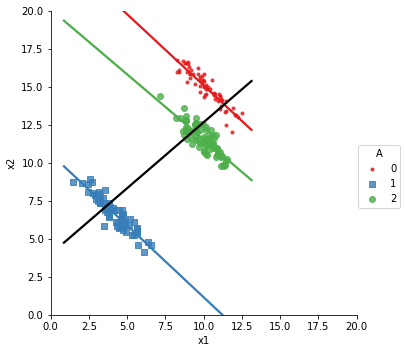

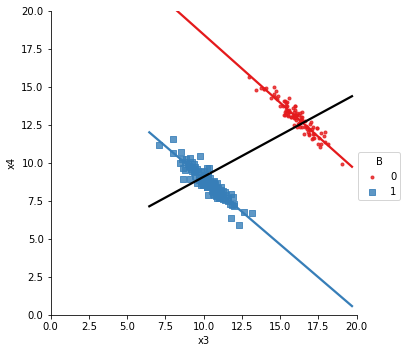

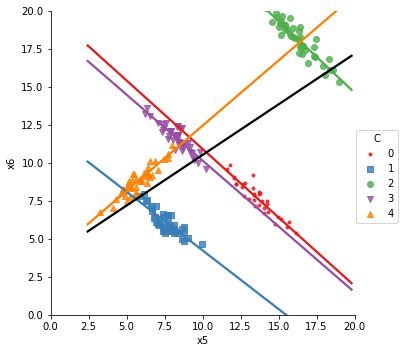

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


We can represent the relationship between the categorical and continuous variables with a binary matrix, that indicates which categorical varialbes represent known clusters in continuous dimensions.  For the above data this is known and specified a priori, at least mostly.  Since they are draw fully independently, it is possible that ther is a high degree of mutual information between two or more categorical variables and then there would be some errors in the matrix below

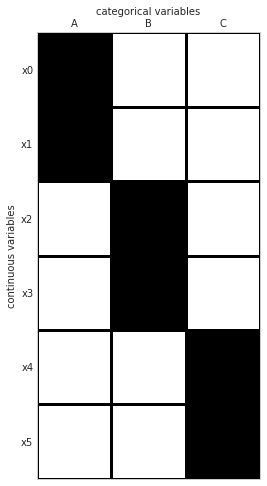

In [4]:
z = [[1, 0, 0],[1, 0, 0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]]
ax = plot_clustermat(z,'list')
plt.xlabel('categorical variables')
plt.gca().xaxis.set_label_position('top') 
plt.xticks([0,1,2],['A','B','C'])
plt.ylabel('continuous variables')
plt.yticks(range(n_views*2),['x'+ str(i) for i in range(n_views*2)]);

We can try clustering into the total number clusters across all views and check what that recovers

In [5]:
kmeans = sklearn.cluster.KMeans(n_clusters=sum(k), random_state=0).fit(many_sp_df_diff.T.loc['x1':'x6'].T)
many_sp_df_diff['kmeans'] = kmeans.labels_


If these clusters relate to the true clusters each one of these clusters would have a single value for each of the true clusters.  For example `kmeans = 0` might correspond to A =0, B=0, C =0. So we can look at the std of each of the categorical variables when we group the data by our found clusters to see how well it works to just cluster across all dimensions

In [6]:
many_sp_df_diff.groupby('kmeans')['A','B','C'].std()

,A,B,C
kmeans,,,
0,1.028992,0.000000,0.000000
1,1.012122,0.000000,1.288788
2,0.000000,0.527046,0.000000
3,1.022620,0.000000,0.485071
4,0.000000,0.000000,1.123903
5,0.000000,0.504525,0.000000
6,0.975900,0.000000,0.000000
7,0.000000,0.000000,1.174218
8,1.003263,0.000000,0.000000


Many are 0, whichc is good, but not all. We would also hope for high mutual information.

In [7]:
print(sklearn.metrics.mutual_info_score(many_sp_df_diff['kmeans'],many_sp_df_diff['A']))
print(sklearn.metrics.mutual_info_score(many_sp_df_diff['kmeans'],many_sp_df_diff['B']))
print(sklearn.metrics.mutual_info_score(many_sp_df_diff['kmeans'],many_sp_df_diff['C']))

0.6288068144287884
0.625732344524177
1.0133660282520744


We can check lookinng at one at a time to confirm that clustering in a sngle view of the data recovers the known structure

In [8]:
dpgmm = mixture.BayesianGaussianMixture(n_components=8,
                                        covariance_type='full').fit(many_sp_df_diff.T.loc['x1':'x2'].T)
many_sp_df_diff['Apred'] = dpgmm.predict(many_sp_df_diff.T.loc['x1':'x2'].T)

In [9]:
dpgmm = mixture.BayesianGaussianMixture(n_components=8,
                                        covariance_type='full').fit(many_sp_df_diff.T.loc['x3':'x4'].T)
many_sp_df_diff['Bpred'] = dpgmm.predict(many_sp_df_diff.T.loc['x3':'x4'].T)

Now we can look at mutual information as well. 

In [10]:
# many_sp_df_diff.apply

sklearn.metrics.mutual_info_score(many_sp_df_diff['A'],many_sp_df_diff['Apred'])

1.0697257599824335

In [11]:
sklearn.metrics.mutual_info_score(many_sp_df_diff['B'],many_sp_df_diff['Bpred'])

0.6926971130356332

In [12]:
many_sp_df_diff.groupby('A')['Apred'].describe()

,count,mean,std,min,25%,50%,75%,max
A,,,,,,,,
0,64.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,62.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,74.0,1.972973,0.232495,0.0,2.0,2.0,2.0,2.0


In [13]:
many_sp_df_diff.groupby('B')['Bpred'].describe()

,count,mean,std,min,25%,50%,75%,max
B,,,,,,,,
0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [14]:
x1,x2 = many_sp_df_diff.columns[:2]
x1
many_sp_df_diff[[x1,x2]].head()

,x1,x2
0,2.047880,8.701604
1,10.873305,10.519449
2,4.301740,6.116435
3,3.132307,8.080181
4,4.574181,6.257364


In [45]:
rho = [.6, .8, .3]
n_rho = len(rho)
off_diag = np.tile(np.asarray([(1-rho_i)/(n_rho-1) for rho_i in rho]),[len(rho),1]).T
off_diag = off_diag - np.diag(np.diag(off_diag)) # zero out diag
p_mat = np.diag(rho) + off_diag
p_mat[1]


array([0.1, 0.8, 0.1])

In [112]:
z = many_sp_df_diff['A'].values
z_opts =[0,1,2]
rho =  [.9, .8, .9]
n_rho = len(rho)
off_diag = np.tile(np.asarray([(1-rho_i)/(n_rho-1) for rho_i in rho]),[len(rho),1]).T
off_diag = off_diag - np.diag(np.diag(off_diag)) # zero out diag
p_mat = np.diag(rho) + off_diag
prob = {z_i:rho_i for z_i,rho_i in zip(set(z),p_mat)}

# sample sing genrated probmat
zp = [np.random.choice(z_opts, p = prob[z_i]) for z_i in z]

In [113]:
sklearn.metrics.normalized_mutual_info_score(many_sp_df_diff['A'],zp)

0.5670527751697567

In [114]:
sum([z_i== zp_i for z_i,zp_i in zip(z,zp)])/len(zp)

0.865

In [37]:
# iterate over pairs of variables in only continuous vars- improve later for if somme are provided


for x1,x2 in itert.combinations(many_sp_df_diff.columns[:6],2):
    # run clustering
    dpgmm = mixture.BayesianGaussianMixture(n_components=20,
                                        covariance_type='full').fit(many_sp_df_diff[[x1,x2]])
    
    # check if clusters are good separation or nonsense
    
    # agument data with clusters
    many_sp_df_diff['clust_'+ x1+ '_' + x2] = dpgmm.predict(many_sp_df_diff[[x1,x2]])


many_sp_df_diff.head()

/home/smb/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


,x1,x2,x3,x4,x5,x6,A,B,C,kmeans,...,clust_x2_x3,clust_x2_x4,clust_x2_x5,clust_x2_x6,clust_x3_x4,clust_x3_x5,clust_x3_x6,clust_x4_x5,clust_x4_x6,clust_x5_x6
0,7.831957,8.144753,13.300520,11.928939,14.465451,16.407821,2,1,0,8,...,7,1,7,0,1,10,5,0,4,3
1,8.094615,8.456364,10.785898,9.756356,14.105026,16.162072,2,0,0,0,...,0,1,11,0,0,6,0,0,1,3
2,4.502107,4.808617,11.050014,14.585463,11.425943,13.697282,0,1,2,3,...,4,3,6,4,1,6,0,0,4,4
3,6.073086,6.393120,13.780783,12.227023,14.798107,12.891942,2,1,3,8,...,7,3,7,4,1,10,5,0,4,4
4,6.443205,6.672176,13.084463,13.366396,6.827182,8.969607,2,1,1,7,...,7,3,6,2,1,4,6,3,13,1


In [38]:
# check that it found the right answers,
many_sp_df_diff[['A','clust_x1_x2']].head()

,A,clust_x1_x2
0,2,3
1,2,3
2,0,5
3,2,3
4,2,3


In [39]:
print('expected unique: ',len(np.unique(many_sp_df_diff['A'])))
print('found unique: ',len(np.unique(many_sp_df_diff['clust_x1_x2'])))
sklearn.metrics.mutual_info_score(many_sp_df_diff['A'],many_sp_df_diff['clust_x1_x2'])

expected unique:  3
found unique:  3


1.0058708264233127

In [40]:
print('expected unique: ',len(np.unique(many_sp_df_diff['B'])))
print('found unique: ',len(np.unique(many_sp_df_diff['clust_x3_x4'])))
sklearn.metrics.mutual_info_score(many_sp_df_diff['B'],many_sp_df_diff['clust_x3_x4'])

# plot with color for true and shape for found

expected unique:  2
found unique:  2


0.6930971797265782

In [41]:
print('expected unique: ',len(np.unique(many_sp_df_diff['C'])))
print('found unique: ',len(np.unique(many_sp_df_diff['clust_x5_x6'])))
sklearn.metrics.mutual_info_score(many_sp_df_diff['C'],many_sp_df_diff['clust_x5_x6'])

expected unique:  5
found unique:  4


0.9192244276566639